In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np

# these are new 
import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import shutil                   # file management tools 
import os                       # operating system tools (check files)

import geopandas as gpd # this is the main geopandas 
from shapely.geometry import Point, Polygon # also needed

##########################
# Then this stuff below allows us to make a nice inset


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

### Create a Map and...

Generate trade exposure metrics for which we can project outcomes at the county/cmz level on changes in trade exposure and/or tariff exposure. The key resource that I am exploiting is the [Quarterly Census of Employment and Wages](https://www.bls.gov/cew/datatoc.htm). 

The process will work like this:

- For 2017, read in the data and construct national level employment and wages by NAICS. Issue here is that we need to be consistent about how stuff is masked at different levels of aggregation. So I will start at county level then work up.


- Merge the national level outcomes with the trade data (at the NAICS) level.


- Then we construct county level "weights". So something like a county's share of national employment by NAICS code, multiply this by total exports of that NAICS code, then sum across all NAICS codes, all for a county. This will aportion exports to a county based on their national level employment share. The sum is a summary measure of a county's exports.


- Outstanding issue is that employment is bottom coded, so small isolated establishments within an NAICS code are not reported. This is where the Dorn strategy of "filling in" might be worth using. For now we will ignore it. 

---

#### Step 1: Read in and clean up the BLS, single file dataset.

In [2]:
url = "https://data.bls.gov/cew/data/files/2017/csv/2017_annual_singlefile.zip"
# This will read in the annual, single file. It's big, but has all we want...

r = requests.get(url) 

In [3]:
# convert bytes to zip file  
bls_sf = zf.ZipFile(io.BytesIO(r.content)) 
print('Type of zipfile object:', type(bls_sf))

Type of zipfile object: <class 'zipfile.ZipFile'>


In [4]:
bls_sf.namelist()

['2017.annual.singlefile.csv']

In [5]:
clist = ['area_fips', 'own_code', 'industry_code', 'agglvl_code', 'size_code',
       'year', 'disclosure_code', 'annual_avg_estabs',
       'annual_avg_emplvl', 'total_annual_wages','avg_annual_pay']

# These are the columns we care about and will grab

[https://data.bls.gov/cew/doc/titles/area/area_titles.htm](https://data.bls.gov/cew/doc/titles/area/area_titles.htm)

In [6]:
df = pd.read_csv(bls_sf.open(bls_sf.namelist()[0]), usecols= clist)

C:\Users\mwaugh.NYC-STERN\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
df.head()

,area_fips,own_code,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,avg_annual_pay
0,1000,0,10,50,0,2017,NaN,124881,1936819,89088710816,45997
1,1000,1,10,51,0,2017,NaN,1208,53131,4339038631,81668
2,1000,1,102,52,0,2017,NaN,1208,53131,4339038631,81668
3,1000,1,1021,53,0,2017,NaN,610,11173,716001109,64083
4,1000,1,1022,53,0,2017,NaN,2,12,369309,30354


In [8]:
df.columns

Index(['area_fips', 'own_code', 'industry_code', 'agglvl_code', 'size_code',
       'year', 'disclosure_code', 'annual_avg_estabs', 'annual_avg_emplvl',
       'total_annual_wages', 'avg_annual_pay'],
      dtype='object')

#### Step 2: Create National Aggregates

Now what we want to do is to create a national dataset for which we can merge on the county....

In [9]:
NAICS_county_level = 75 
# This is the code that will select only counties at the 4 digit NAICS level
#https://data.bls.gov/cew/doc/titles/agglevel/agglevel_titles.htm

df_county = df[df.agglvl_code == NAICS_county_level].copy()

df_county = df_county[df_county.own_code == 5]
# Only grab private stuff

df_county = df_county[(df_county.area_fips.str[0:2] != "72") & (df_county.area_fips.str[0:2] != "78")
              & (df_county.area_fips.str[0:2] != "02") & (df_county.area_fips.str[0:2] != "15")]
#Drop puerto rico, alaska, hawaii...

df_county["sup_ind"] = df_county.industry_code.str[1].astype(int)
# sometimes there are super industries floating around we want to drop them.
# not clear if this matters with the conditioning all ready

df_county = df_county[df_county["sup_ind"] > 0]

Then once we have this, we group by NAICS code, then sum across employment. This should give, conditional on the county/naics aggregation, the consistent national level totals.

In [10]:
df_national = df_county.groupby("industry_code").agg({"annual_avg_emplvl": "sum"})

In [11]:
df_national.reset_index(inplace = True)

In [12]:
df_national.shape

(92, 2)

---
#### Step 3. Merge national aggregates with trade data

This section has been enhanced modified so that we can construct stuff from the tariff line and then map into NAICS. So the first step is to pull in the trade data at the HS6 level....

In [13]:
#
#end_use = "naics?get=NAICS,CTY_CODE,ALL_VAL_MO,CTY_NAME"
#url = "https://api.census.gov/data/timeseries/intltrade/exports/" + end_use + my_key + "&time==from+2017-01" + "&COMM_LVL=NA6"
#url = url + "&CTY_CODE=5700"

In [15]:
my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"

end_use = "hs?get=E_COMMODITY,CTY_CODE,ALL_VAL_MO,CTY_NAME"

url = "https://api.census.gov/data/timeseries/intltrade/exports/" + end_use + my_key + "&time==from+2017-01" + "&COMM_LVL=HS6"

url = url + "&CTY_CODE=5700"

In [16]:
r = requests.get(url) 

r

<Response [200]>

In [17]:
dftrade = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
# Note that the first entry is the labels

dftrade.columns = r.json()[0]

dftrade.time = pd.to_datetime(dftrade.time, format="%Y-%m")
# This is so I can call this correctly...

dftrade.ALL_VAL_MO = dftrade.ALL_VAL_MO.astype(float)

dftrade.head(10)

,E_COMMODITY,CTY_CODE,ALL_VAL_MO,CTY_NAME,time,COMM_LVL,CTY_CODE
0,854121,5700,4843669.0,CHINA,2017-01-01,HS6,5700
1,854231,5700,285025279.0,CHINA,2017-01-01,HS6,5700
2,848490,5700,2372135.0,CHINA,2017-01-01,HS6,5700
3,848710,5700,22596.0,CHINA,2017-01-01,HS6,5700
4,850110,5700,3420040.0,CHINA,2017-01-01,HS6,5700
5,850161,5700,33787.0,CHINA,2017-01-01,HS6,5700
6,850432,5700,156732.0,CHINA,2017-01-01,HS6,5700
7,850520,5700,249613.0,CHINA,2017-01-01,HS6,5700
8,851490,5700,1548589.0,CHINA,2017-01-01,HS6,5700
9,851680,5700,3167865.0,CHINA,2017-01-01,HS6,5700


In [18]:
dftrade.set_index("time", inplace = True)

In [19]:
#df17naics_trade = dftrade.loc["2017"].groupby("NAICS").agg({"ALL_VAL_MO":"sum"})


df17naics_trade = dftrade.loc["2017"].groupby("E_COMMODITY").agg({"ALL_VAL_MO":"sum"})

Alot going on here, grab 2017, groupby NAICS code, then compute the sum. So for a given NAICS code, this will be summing across all observations, which in this case is across months. Thus this is annual exports, by NAICS codes.

In [20]:
df17naics_trade.head()

,ALL_VAL_MO
E_COMMODITY,
010121,29098.0
010129,27975.0
010130,11082.0
010221,80280.0
010229,2682.0


In [21]:
df17naics_trade.shape

(4281, 1)

Then what we want to do is to construct concordances from the HS level to the NAICS level...

In [22]:
url = "https://www.census.gov/foreign-trade/reference/codes/concordance/expconcord17.xls"

df_concordance = pd.read_excel(url, dtype = {"commodity": str, "naics": str})

df_concordance["hs8"] = df_concordance.commodity.str[0:8]
# truncate down to get the hs8

df_concordance["hs6"] = df_concordance.commodity.str[0:6]
# truncate down to get the hs6

dict_concordance = dict(zip(df_concordance.hs6,df_concordance.naics)) 

# This creates a dictionaty from which we can map the hs6 to the naics codes

Then what we do is use the `.map` on the dictionary to create the associated naics values

In [23]:
df17naics_trade["hs6"] = df17naics_trade.index

df17naics_trade["naics"] = df17naics_trade["hs6"].map(dict_concordance)

In [24]:
df17naics_trade.head()

,ALL_VAL_MO,hs6,naics
E_COMMODITY,,,
010121,29098.0,010121,112920
010129,27975.0,010129,112920
010130,11082.0,010130,112920
010221,80280.0,010221,11211X
010229,2682.0,010229,11211X


Then read in the tariff file. This was created from the ``hscodes_naics.ipynb``...

In [25]:
tariffs = pd.read_csv("tariff_list_naics.csv", dtype = {"HS-8 code": str,"HS6": str,"naics": str,"naics4": str})

tariffs.time_of_tariff = pd.to_datetime(tariffs.time_of_tariff, format="%Y-%m-%d")

tariffs.set_index("time_of_tariff",inplace = True)

In [26]:
tariffs.head()

,HS-8 code,Product description,tariff,HS6,naics,naics4
time_of_tariff,,,,,,
2018-07-06,02012000,Fresh or chilled unboned bovine meat ( excl. c...,25,020120,311611,3116
2018-07-06,02013000,Fresh or chilled boneless bovine meat,25,020130,311611,3116
2018-07-06,02021000,Frozen bovine carcasses & half carcasses,25,020210,311611,3116
2018-07-06,02022000,Frozen unboned bovine meat (excl. carcasses),25,020220,311611,3116
2018-07-06,02023000,Frozen boneless bovine meat,25,020230,311611,3116


Then we want to create a tariff column depending upon the round...

In [27]:
tariff_dict = dict(zip(tariffs.loc["2018-07-06"].HS6,tariffs.loc["2018-07-06"].tariff)) 

df17naics_trade["r1"] = df17naics_trade["hs6"].map(tariff_dict)

df17naics_trade["r1"].replace(np.nan,0,inplace = True)

round1_tariff = df17naics_trade[df17naics_trade["r1"] == 25].ALL_VAL_MO.sum()

print("Round 1 Tariff", round1_tariff)

Round 1 Tariff 29166199809.0


In [28]:
tariff_dict = dict(zip(tariffs.loc[dt.datetime(2018,8,23)].HS6,tariffs.loc[dt.datetime(2018,8,23)].tariff)) 

df17naics_trade["r2"] = df17naics_trade["hs6"].map(tariff_dict)

df17naics_trade["r2"].replace(np.nan,0,inplace = True)

round2_tariff = df17naics_trade[df17naics_trade["r2"] == 25].ALL_VAL_MO.sum()

print("Round 1 Tariff", round2_tariff)

print("Total for 50bill list",round1_tariff + round2_tariff)

Round 1 Tariff 21080660023.0
Total for 50bill list 50246859832.0


In [29]:
tariff_dict = dict(zip(tariffs.loc[dt.datetime(2018,9,24)].HS6,tariffs.loc[dt.datetime(2018,9,24)].tariff)) 

df17naics_trade["r3"] = df17naics_trade["hs6"].map(tariff_dict)

round3_tariff = df17naics_trade[~df17naics_trade["r3"].isna()].ALL_VAL_MO.sum()

df17naics_trade["r3"].replace(np.nan,0,inplace = True)

print("Total for 60bill list", round3_tariff)

Total for 60bill list 51334062656.0


In [30]:
df17naics_trade["naics4"] = df17naics_trade["naics"].str[0:4]

df17naics_trade["naics3"] = df17naics_trade["naics"].str[0:3]

In [31]:
df17naics_trade.head(10)

,ALL_VAL_MO,hs6,naics,r1,r2,r3,naics4,naics3
E_COMMODITY,,,,,,,,
010121,29098.0,010121,112920,0.0,0.0,0.0,1129,112
010129,27975.0,010129,112920,0.0,0.0,10.0,1129,112
010130,11082.0,010130,112920,0.0,0.0,0.0,1129,112
010221,80280.0,010221,11211X,0.0,0.0,0.0,1121,112
010229,2682.0,010229,11211X,0.0,0.0,0.0,1121,112
010231,3806.0,010231,11211X,0.0,0.0,0.0,1121,112
010239,5000.0,010239,11211X,0.0,0.0,0.0,1121,112
010310,10068288.0,010310,112210,0.0,0.0,0.0,1122,112
010391,30877.0,010391,112210,0.0,0.0,0.0,1122,112


Then the **big picture** is this. Take the df from above, group it on the NAICS code. As we group it, we will construct the average tariff rate **within** the naics code. Some some products within the NAICS codes have tariffs, some don't. We want to take this into account.

In [32]:
def trade_by_naics(df):
    # Simple function just to test about aggregation 
    
    return df["ALL_VAL_MO"].sum()

In [33]:
def trd_weighted_avg(df):
    # A function to create the trade weighted average of the tariff rates
    # by round...
    
    trd_w_avg = df[["r1","r2","r3"]].multiply(df["ALL_VAL_MO"],axis = 0).sum() 
    
    trd_w_avg = trd_w_avg / df["ALL_VAL_MO"].sum()
    
    foo = {"tariff_r1": [trd_w_avg.r1], 
           "tariff_r2": [trd_w_avg.r2],
           "tariff_r3": [trd_w_avg.r3],
           "total_trade": df["ALL_VAL_MO"].sum()}
    
    return pd.DataFrame(foo, index = [df.naics4.iloc[0]])

In [34]:
grp = df17naics_trade.groupby("naics3")

In [35]:
dfnaics_tariffs = grp.apply(trd_weighted_avg)

In [36]:
dfnaics_tariffs.total_trade.sum()

129893586716.0

In [37]:
dfnaics_tariffs.shape

(30, 4)

In [38]:
dfnaics_tariffs = dfnaics_tariffs.droplevel(1)

In [39]:
dfnaics_tariffs.head()

,tariff_r1,tariff_r2,tariff_r3,total_trade
naics3,,,,
111,24.659308,0.000000,0.032653,1.579156e+10
112,0.247194,0.000000,6.783315,1.062895e+08
113,0.000000,0.000000,4.332380,1.322845e+09
114,23.261587,1.644786,0.679406,1.321707e+09
211,0.000000,7.242140,0.623951,6.792391e+09


In [40]:
dfnaics_tariffs.total_trade.sum()

129893586716.0

Then merge it with the national level NAICS. Note the groupby operation above leaves the index as the naics code left is on the industry code. Default here is inner, need to think about if I want to carry around zeros.

In [41]:
df_nation_naics = df_national.merge(dfnaics_tariffs, how = "outer", left_on = "industry_code", right_index = True)


In [44]:
df_nation_naics.head()

,industry_code,annual_avg_emplvl,tariff_r1,tariff_r2,tariff_r3,total_trade
0,111,534697.0,24.659308,0.000000,0.032653,1.579156e+10
1,112,228471.0,0.247194,0.000000,6.783315,1.062895e+08
2,113,45166.0,0.000000,0.000000,4.332380,1.322845e+09
3,114,5005.0,23.261587,1.644786,0.679406,1.321707e+09
4,115,352957.0,NaN,NaN,NaN,NaN


In [45]:
print("number of NAICS codes with trade", df_nation_naics.shape[0])
print("national employment", df_nation_naics.annual_avg_emplvl.sum())
print("Potential China Export Employment",df_nation_naics.annual_avg_emplvl.sum())
print("Total Trade",df_nation_naics.total_trade.sum())

number of NAICS codes with trade 95
national employment 115756851.0
Potential China Export Employment 115756851.0
Total Trade 129893586716.0


In [46]:
df_nation_naics.head()

,industry_code,annual_avg_emplvl,tariff_r1,tariff_r2,tariff_r3,total_trade
0,111,534697.0,24.659308,0.000000,0.032653,1.579156e+10
1,112,228471.0,0.247194,0.000000,6.783315,1.062895e+08
2,113,45166.0,0.000000,0.000000,4.332380,1.322845e+09
3,114,5005.0,23.261587,1.644786,0.679406,1.321707e+09
4,115,352957.0,NaN,NaN,NaN,NaN


In [47]:
df_nation_naics.rename({"annual_avg_emplvl":"nat_emplvl",
                        "total_trade": "china_exports"}, axis = 1, inplace = True)

In [48]:
df_nation_naics.china_exports.replace(np.nan, 0, inplace = True)

In [49]:
df_nation_naics.head()

,industry_code,nat_emplvl,tariff_r1,tariff_r2,tariff_r3,china_exports
0,111,534697.0,24.659308,0.000000,0.032653,1.579156e+10
1,112,228471.0,0.247194,0.000000,6.783315,1.062895e+08
2,113,45166.0,0.000000,0.000000,4.332380,1.322845e+09
3,114,5005.0,23.261587,1.644786,0.679406,1.321707e+09
4,115,352957.0,NaN,NaN,NaN,0.000000e+00


#### Step 4: Clean county level data to line up with national aggregates

What I want to do now is rename and probably drop a bunch of this stuff. Then merge it on the national df on the industry code. A think I need to figure out is to only have the county fips codes

In [50]:
df_county.head(10)

,area_fips,own_code,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,avg_annual_pay,sup_ind
3016,1001,5,111,75,0,2017,N,4,0,0,0,1
3026,1001,5,112,75,0,2017,NaN,3,27,848146,31905,1
3033,1001,5,113,75,0,2017,NaN,4,36,2901165,80032,1
3040,1001,5,115,75,0,2017,NaN,9,27,2007731,74132,1
3052,1001,5,212,75,0,2017,N,4,0,0,0,1
3057,1001,5,221,75,0,2017,NaN,5,106,11595556,109564,2
3067,1001,5,236,75,0,2017,NaN,21,72,1547556,21644,3
3077,1001,5,237,75,0,2017,NaN,8,64,4492517,69832,3
3091,1001,5,238,75,0,2017,NaN,55,313,12704765,40601,3
3136,1001,5,311,75,0,2017,N,1,0,0,0,1


Below this is just exploring some issues with this. One thing that jumps out is not all NAICS codes are represented within a County. At somepoint need to explore why

In [51]:
df_county.annual_avg_emplvl.sum()

115756851

In [52]:
df_nation_naics.china_exports.sum()

129893586716.0

In [53]:
grp = df_county.groupby("area_fips")

In [54]:
grp.get_group(10003).head()

,area_fips,own_code,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,total_annual_wages,avg_annual_pay,sup_ind
332499,10003,5,111,75,0,2017,N,18,0,0,0,1
332521,10003,5,112,75,0,2017,N,2,0,0,0,1
332528,10003,5,115,75,0,2017,N,7,0,0,0,1
332537,10003,5,213,75,0,2017,N,1,0,0,0,1
332542,10003,5,221,75,0,2017,NaN,25,1573,185106962,117690,2


In [55]:
def create_trade_exposure(df):

    new_df = df.merge(df_nation_naics, how = "outer", left_on = "industry_code", right_on = "industry_code")
    # Merge the nation with the county, why, we want to make sure all the naics codes are lined up properly
    
    naics_codes = df_nation_naics.shape[0]
    
    cnty_weights = (new_df.annual_avg_emplvl/new_df.nat_emplvl)
    
    county_share = cnty_weights*(new_df.china_exports)
    # Then at the NAICS level, take a county's employment relative th national employment. 
    # This is like the weight. Then multiply it by NAICS exports. So this is like if LA has 5 percernt in X,
    # Then 5 percent of X's exports go to LA. 
    
    tariff_exp_r1 = cnty_weights*(new_df.china_exports/new_df.china_exports.sum())
                                                                                    
    tariff_exp_r1 = tariff_exp_r1*(new_df.tariff_r1 + new_df.tariff_r2 + new_df.tariff_r3)
    
    tariff_exp_r1 = (1/new_df.annual_avg_emplvl.sum())*(tariff_exp_r1.sum())
        
    trd_exp = (1/new_df.annual_avg_emplvl.sum())*county_share.sum()
    # Then sum acrross all the NAICS codes
    #trd_exp = county_share.sum()
    
    foo = {"export_exposure": [trd_exp], "tariff_exp_r1": [tariff_exp_r1],
           "employment": [new_df.annual_avg_emplvl.sum()]}
    
    return pd.DataFrame(foo, index = [new_df.area_fips.iloc[0]])
    

In [56]:
single_location = create_trade_exposure(grp.get_group(10001))

In [57]:
single_location

,export_exposure,tariff_exp_r1,employment
10001,512.96636,7.551560e-08,29514.0


In [58]:
single_location = create_trade_exposure(grp.get_group(10001))

In [59]:
df_trdx_county = grp.apply(create_trade_exposure)

C:\Users\mwaugh.NYC-STERN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\mwaugh.NYC-STERN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\mwaugh.NYC-STERN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\mwaugh.NYC-STERN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


In [60]:
df_trdx_county = df_trdx_county.droplevel(1)

In [61]:
df_trdx_county.corr()

,export_exposure,tariff_exp_r1,employment
export_exposure,1.000000,0.869852,-0.059318
tariff_exp_r1,0.869852,1.000000,-0.063938
employment,-0.059318,-0.063938,1.000000


In [67]:
df_trdx_county["q_tariff"] = pd.qcut(df_trdx_county["tariff_exp_r1"], 11 ,labels = False, duplicates='drop')

In [68]:
df_trdx_county.sort_values(by = ["q_tariff"], ascending = False).head()

,export_exposure,tariff_exp_r1,employment,q_tariff
area_fips,,,,
72121,9851.729991,1.850605e-06,581.0,10.0
8109,9126.279358,1.734849e-06,699.0,10.0
20109,3078.797911,5.852603e-07,259.0,10.0
53069,16251.553987,5.420429e-07,164.0,10.0
20129,4660.095976,8.821343e-07,153.0,10.0


In [71]:
df_trdx_county["q_trx"] = pd.qcut(df_trdx_county["export_exposure"], 11 ,labels = False, duplicates='drop')

In [72]:
df_trdx_county.sort_values(by = ["q_trx"], ascending = False).head()

,export_exposure,tariff_exp_r1,employment,q_tariff,q_trx
area_fips,,,,,
72121,9851.729991,1.850605e-06,581.0,10.0,10.0
13007,16309.629839,3.100359e-06,67.0,10.0,10.0
13061,13736.583271,2.611239e-06,43.0,10.0,10.0
38081,4077.459666,7.723928e-07,444.0,10.0,10.0
38095,8616.182764,1.617335e-06,157.0,10.0,10.0


### Step 5: Make the MAP

In [73]:
cwd = os.getcwd()

hpz640 = "C:\\Users\\mwaugh.NYC-STERN\\Documents\\GitHub\\data_bootcamp_spring_2019\\mapping\\shape_file\\US"

regions_shape = hpz640 + "\\tl_2017_us_county.shx"

In [74]:
us_map = gpd.read_file(regions_shape)

In [75]:
us_map.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477641638,10701538,+41.9158651,-096.7885168,"POLYGON ((-97.019516 42.004097, -97.019519 42...."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680956787,61588406,+46.2946377,-123.4244583,"POLYGON ((-123.436394 46.238197, -123.447592 4..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016761648,29147345,+34.3592729,-104.3686961,"POLYGON ((-104.567387 33.997566, -104.567717 3..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169252486,22867561,+40.7835474,-096.6886584,"POLYGON ((-96.91059899999999 40.958407, -96.91..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645186,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27366699999999 40.089399, -98.27..."


In [76]:
us_map["area_fips"] = (us_map.STATEFP.astype(str) + us_map.COUNTYFP.astype(str)).astype(int)

In [77]:
us_map = us_map.merge(df_trdx_county, on='area_fips', how = "inner", indicator = True)

In [78]:
us_map.set_index("STATEFP", inplace = True)

In [79]:
drop_list = ["02","15","72"]

us_map.drop(drop_list, inplace = True)

In [80]:
us_map.q_trx.replace(np.nan,0,inplace = True)

us_map.q_tariff.replace(np.nan,0,inplace = True)

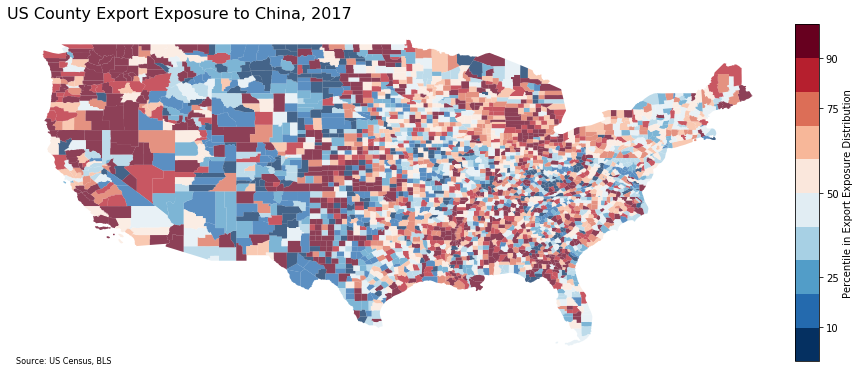

In [81]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,1,figsize = (12,8))

plt.tight_layout()
plt.rcParams.update(plt.rcParamsDefault) # This will reset defaluts...

#################################################################################
# This is for the colorbar...

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="3%", pad=0.1)

#################################################################################
## This creates a discrete colorbar scheme...
# https://gist.github.com/jakevdp/91077b0cae40f8f8244a

N = 10

base = plt.cm.get_cmap("RdBu_r")

color_list = base(np.linspace(0, 1, N))

cmap_name = base.name + str(N)

dcmap =  base.from_list(cmap_name, color_list, N)

#################################################################################
# This is the normal mapping...

us_map.plot(column='q_trx', ax = ax,
              # THIS IS NEW, it says color it based on this column
             cmap=dcmap, 
             alpha = 0.75,
             vmin=0, vmax=us_map.q_trx.max())

#################################################################################
# This then alows me to generate and edit the colorbar....
# https://stackoverflow.com/questions/53158096/editing-colorbar-legend-in-geopandas

sm = plt.cm.ScalarMappable(cmap=dcmap)
sm._A = []
cbr = fig.colorbar(sm, cax=cax)

cbr.set_label('Percentile in Export Exposure Distribution')
cbr.set_alpha(0.15)

cbr.set_ticks([0.10, 0.25,0.50,0.75, 0.90])
cbr.set_ticklabels(["10","25","50","75","90"], update_ticks=True)

#################################################################################
# Then some final stuff to clean things up....

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.get_xaxis().set_visible(False)

ax.get_yaxis().set_visible(False)

ax.set_title("US County Export Exposure to China, 2017", fontsize = 16, loc= "left" )

ax.text(-127,23, "Source: US Census, BLS", fontsize = 8)

#plt.savefig("us_china_exports_map.pdf", bbox_inches = "tight", dip = 1200)

plt.show()

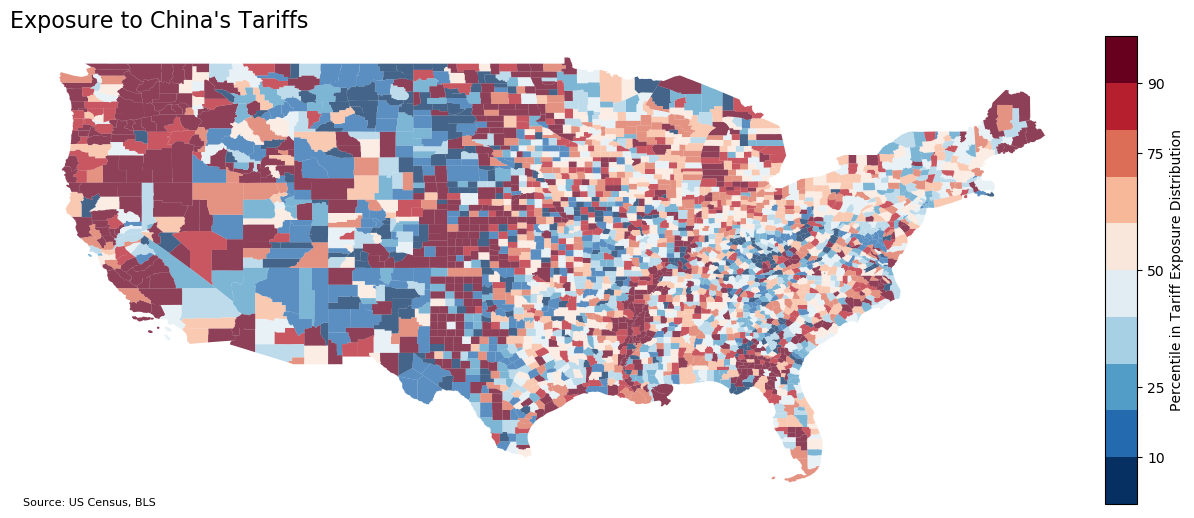

In [82]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,1,figsize = (12,8))

plt.tight_layout()
plt.rcParams.update(plt.rcParamsDefault) # This will reset defaluts...

#################################################################################
# This is for the colorbar...

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="3%", pad=0.1)

#################################################################################
## This creates a discrete colorbar scheme...
# https://gist.github.com/jakevdp/91077b0cae40f8f8244a

N = 10

base = plt.cm.get_cmap("RdBu_r")

color_list = base(np.linspace(0, 1, N))

cmap_name = base.name + str(N)

dcmap =  base.from_list(cmap_name, color_list, N)

#################################################################################
# This is the normal mapping...

us_map.plot(column='q_tariff', ax = ax,
              # THIS IS NEW, it says color it based on this column
             cmap=dcmap, 
             alpha = 0.75,
             vmin=0, vmax=us_map.q_tariff.max())

#################################################################################
# This then alows me to generate and edit the colorbar....
# https://stackoverflow.com/questions/53158096/editing-colorbar-legend-in-geopandas

sm = plt.cm.ScalarMappable(cmap=dcmap)
sm._A = []
cbr = fig.colorbar(sm, cax=cax)

cbr.set_label('Percentile in Tariff Exposure Distribution')
cbr.set_alpha(0.15)

cbr.set_ticks([0.10, 0.25,0.50,0.75, 0.90])
cbr.set_ticklabels(["10","25","50","75","90"], update_ticks=True)

#################################################################################
# Then some final stuff to clean things up....

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.get_xaxis().set_visible(False)

ax.get_yaxis().set_visible(False)

ax.set_title("Exposure to China's Tariffs", fontsize = 16, loc= "left" )

ax.text(-127,23, "Source: US Census, BLS", fontsize = 8)

#plt.savefig("us_china_tariff_map.pdf", bbox_inches = "tight", dip = 1200)

plt.show()